In [1]:
import os
import math
import random
import argparse
from collections import Counter, defaultdict
from itertools import chain, combinations
import ast
import copy
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.linear_model import LogisticRegression


In [2]:
from Nash import find_nash_equilibria_v2
from Functions import compute_and_visualize_shapley_values


# HuGa Dataset

In [3]:
train_files_pattern = ".../data/metadata/train_{i:02d}.csv" # Adjust the path as needed
test_files_pattern = ".../data/metadata/test_{i:02d}.csv" # Adjust the path as needed

### Creating Global Train set and Test set

In [4]:
# Load training and testing datasets
df_train_global = pd.concat([pd.read_csv(train_files_pattern.format(i=i)) for i in range(1, 11)]).dropna()
X_train_global = df_train_global.drop('act', axis=1)
y_train_global = df_train_global['act']

df_test_global = pd.concat([pd.read_csv(test_files_pattern.format(i=i)) for i in range(1, 11)]).dropna()
X_test_global = df_test_global.drop('act', axis=1)
y_test_global = df_test_global['act']

# Encode labels
label_encoder = LabelEncoder()
y_train_global = label_encoder.fit_transform(y_train_global)
y_test_global = label_encoder.transform(y_test_global)

# Scale features
scaler = StandardScaler()
X_train_global_scaled = scaler.fit_transform(X_train_global)
X_test_global_scaled = scaler.transform(X_test_global)


In [5]:
# disable ConvergenceWarnings
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

#### Centrelized Training

  0%|          | 0/1 [00:00<?, ?it/s]


Confusion Matrix for Trial 1:
[[ 3069  2308     4    73  1531   148  5388]
 [ 1334  3722     5   224  1783   263  5425]
 [    0     0  7595     0     0     0     0]
 [   11    59   320  1165    46     0   335]
 [   69     8     6     4 22427    11  4145]
 [    2   119   369     0   394  1339   139]
 [ 1680  2170    10   157  6069   137 28238]]


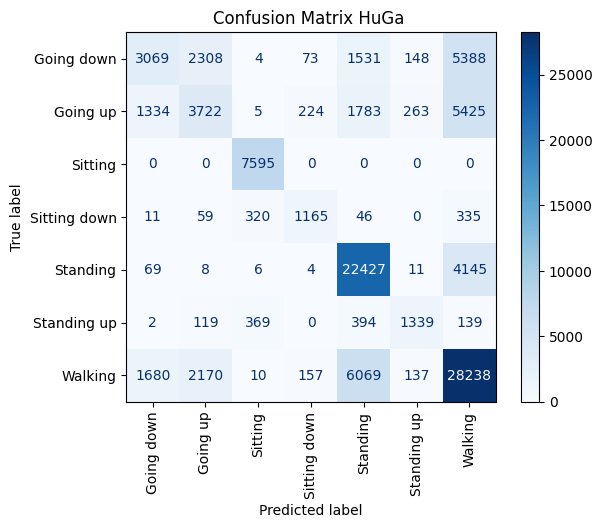

100%|██████████| 1/1 [00:03<00:00,  3.90s/it]

Trial 1/1 - Global test accuracy: 0.6603552262441227


In [9]:
# Parameters
n_trials = 1
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)

results_global = []

for trial in tqdm(range(n_trials)):
    
    # Initialize Logistic Regression model
    model = LogisticRegression(random_state=42, max_iter=1000)  
    model.fit(X_train_global_scaled, y_train_global)  
    
    # Predict on the test set
    y_pred = model.predict(X_test_global_scaled)
    acc_test = accuracy_score(y_test_global, y_pred)  # Compute test accuracy
    
    # Confusion matrix
    cm = confusion_matrix(y_test_global, y_pred)
    print(f"\nConfusion Matrix for Trial {trial + 1}:")
    print(cm)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
    plt.title(f"Confusion Matrix HuGa ")
    plt.show()
    
    results_global.append(acc_test)
    
    print(f"Trial {trial + 1}/{n_trials} - Global test accuracy: {acc_test}")

#### FL

In [6]:
def aggregate_lr_models(models: list):

  aggregated_model = LogisticRegression(random_state=random_seed)
  aggregated_model.coef_ = np.mean([model.coef_ for model in models], axis=0)
  aggregated_model.intercept_ = np.mean([model.intercept_ for model in models], axis=0)
  aggregated_model.classes_ = models[0].classes_

  return aggregated_model


In [9]:
# Parameters
n_clients = 10
n_trials = 1
random_seed = 42

results = []

for trial in range(n_trials):
    print(f"Trial {trial + 1}/{n_trials}")


    # Train models for the clients
    client_models = []
    client_global_accuracies = []
    for i in range(n_clients):
        # Load client-specific training data
        df_train_i = pd.read_csv(train_files_pattern.format(i=i+1)).dropna(subset=['act'])
        X_train = df_train_i.drop('act', axis=1)
        y_train = label_encoder.transform(df_train_i['act'])

        # Train a Logistic Regression model for the client
        model = LogisticRegression(random_state=random_seed + trial, max_iter=1000)
        model.fit(scaler.fit_transform(X_train), y_train)  # Scale the data
        client_models.append(model)

        # Evaluate the model globally
        y_pred_global = model.predict(X_test_global_scaled)
        acc_global = accuracy_score(y_test_global, y_pred_global)
        client_global_accuracies.append(acc_global)

    # Evaluate all combinations of models
    n_combinations = 2 ** n_clients
    for i in tqdm(range(1, n_combinations)):
        bin_str = format(i, f'0{n_clients}b')
        client_indices = [j for j in range(n_clients) if bin_str[n_clients - 1 - j] == '1']
        included_models = [client_models[j] for j in client_indices]

        if not included_models:
            continue

        # Aggregate the models
        aggregated_model = aggregate_lr_models(included_models)

        # Evaluate the aggregated model globally
        y_pred_global = aggregated_model.predict(X_test_global_scaled)
        acc_global = accuracy_score(y_test_global, y_pred_global)

        # Prepare the result row
        row = {
            'Trial': trial + 1,
            'Combination': bin_str,
            'Clients': [j + 1 for j in client_indices],
            'Global Accuracy': acc_global
        }

        for j in range(n_clients):
            row[f'Client {j + 1} Accuracy'] = client_global_accuracies[j]  # Accuracy on global test set
        results.append(row)

# Save results to CSV
df_results = pd.DataFrame(results)
df_results.to_csv("HuG_results_with_LR.csv", index=False)

Trial 1/1


100%|██████████| 1023/1023 [00:06<00:00, 156.27it/s]


In [10]:
df_results.sort_values(by=['Global Accuracy'], ascending=False).head(5)

,Trial,Combination,Clients,Global Accuracy,Client 1 Accuracy,Client 2 Accuracy,Client 3 Accuracy,Client 4 Accuracy,Client 5 Accuracy,Client 6 Accuracy,Client 7 Accuracy,Client 8 Accuracy,Client 9 Accuracy,Client 10 Accuracy
92,1,0001011101,"[1, 3, 4, 5, 7]",0.655780,0.462097,0.400768,0.600317,0.599623,0.611157,0.565195,0.603855,0.592467,0.574168,0.555136
220,1,0011011101,"[1, 3, 4, 5, 7, 8]",0.655253,0.462097,0.400768,0.600317,0.599623,0.611157,0.565195,0.603855,0.592467,0.574168,0.555136
204,1,0011001101,"[1, 3, 4, 7, 8]",0.654695,0.462097,0.400768,0.600317,0.599623,0.611157,0.565195,0.603855,0.592467,0.574168,0.555136
460,1,0111001101,"[1, 3, 4, 7, 8, 9]",0.654001,0.462097,0.400768,0.600317,0.599623,0.611157,0.565195,0.603855,0.592467,0.574168,0.555136
252,1,0011111101,"[1, 3, 4, 5, 6, 7, 8]",0.653943,0.462097,0.400768,0.600317,0.599623,0.611157,0.565195,0.603855,0.592467,0.574168,0.555136


In [11]:
nash_df = find_nash_equilibria_v2(df_results)
nash_df

,Combination,Trial,Clients,Global Accuracy
0,0000000011,1,"[1, 2]",0.471286
1,1111111111,1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",0.645829


      Client  Local Accuracy  Normalized Shapley Value
6   Client 7        0.603855                  0.122054
4   Client 5        0.611157                  0.121466
2   Client 3        0.600317                  0.114309
3   Client 4        0.599623                  0.114009
7   Client 8        0.592467                  0.111752
8   Client 9        0.574168                  0.111305
9  Client 10        0.555136                  0.103522
5   Client 6        0.565195                  0.102073
0   Client 1        0.462097                  0.073259
1   Client 2        0.400768                  0.026250


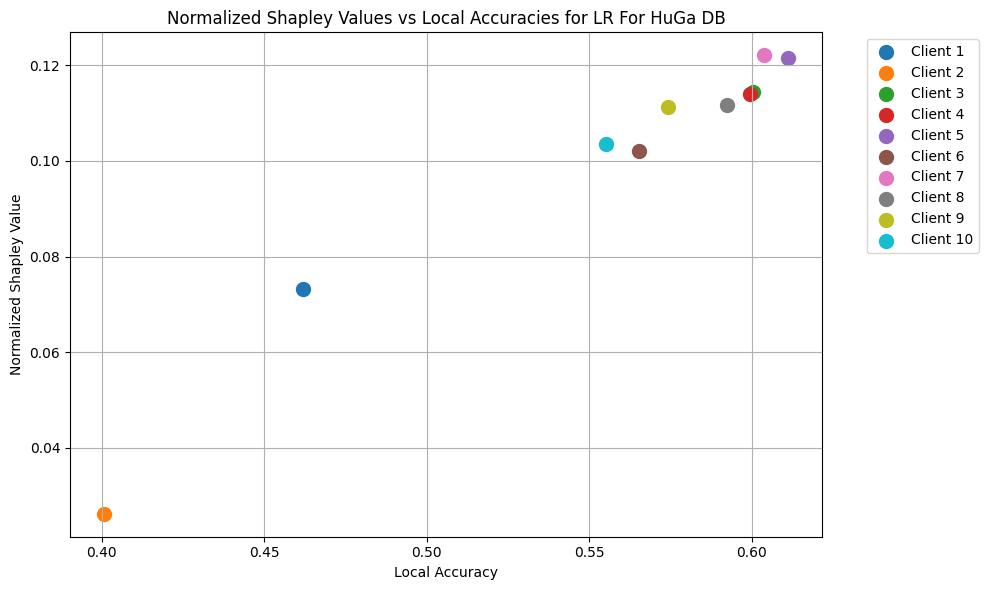

In [14]:
result = compute_and_visualize_shapley_values(
    df_results, 
    client_local_accuracies={i: client_global_accuracies[i] for i in range(n_clients)}, 
    n_clients=10,  
    plot=True,  
    model_name="LR For HuGa DB",  
    print_df=True 
)


## Checking Nash For HuGa in Different subsample_ratios and Different Max_iter

In [ ]:
# Parameters 
n_clients = 10
n_trials = 10
base_random_seed = 42
subsample_ratios = [0.5, 0.6, 0.7, 0.8]  
max_iters = [10, 100]                    


all_results = []                  
all_nash_equilibrium_counts = [] 
all_nash_details = []            

# Loop over each combination of subsample_ratio and max_iter
for subsample_ratio in subsample_ratios:
    for max_iter in max_iters:
        print(f"\nRunning experiment with subsample_ratio = {subsample_ratio}, max_iter = {max_iter}")
        results = []
        nash_equilibrium_counts = Counter()
        nash_details_all = []

        for trial in range(n_trials):
            print(f"  Trial {trial + 1}/{n_trials} for subsample_ratio={subsample_ratio}, max_iter={max_iter}")

            # Set a different random seed for each trial
            trial_seed = base_random_seed + trial
            random.seed(trial_seed)
            np.random.seed(trial_seed)

            # Load and subsample the global training dataset for this trial
            df_train_global = pd.concat([
                pd.read_csv(train_files_pattern.format(i=i)) for i in range(1, 11)
            ]).dropna()
            df_train_global = df_train_global.sample(frac=subsample_ratio, random_state=trial_seed).reset_index(drop=True)

            X_train_global = df_train_global.drop('act', axis=1)
            y_train_global = df_train_global['act']

            # Load and subsample the global testing dataset for this trial
            df_test_global = pd.concat([
                pd.read_csv(test_files_pattern.format(i=i)) for i in range(1, 11)
            ]).dropna()
            df_test_global = df_test_global.sample(frac=subsample_ratio, random_state=trial_seed).reset_index(drop=True)

            X_test_global = df_test_global.drop('act', axis=1)
            y_test_global = df_test_global['act']

            # Encode labels
            label_encoder = LabelEncoder()
            y_train_global = label_encoder.fit_transform(y_train_global)
            y_test_global = label_encoder.transform(y_test_global)

            # Scale features
            scaler = StandardScaler()
            X_train_global_scaled = scaler.fit_transform(X_train_global)
            X_test_global_scaled = scaler.transform(X_test_global)

            # Function to aggregate logistic regression models with added randomness
            def aggregate_lr_models(models: list):
                aggregated_model = LogisticRegression()
                aggregated_model.coef_ = np.mean([model.coef_ for model in models], axis=0)
                noise = np.random.normal(0, 0.05, aggregated_model.coef_.shape)
                aggregated_model.coef_ += noise
                aggregated_model.intercept_ = np.mean([model.intercept_ for model in models], axis=0)
                aggregated_model.classes_ = models[0].classes_
                return aggregated_model

            # Train models for each client and record their global accuracies
            client_models = []
            client_global_accuracies = {}
            for i in range(n_clients):
                df_train_i = pd.read_csv(train_files_pattern.format(i=i+1)).dropna(subset=['act'])
                df_train_i = df_train_i.sample(frac=subsample_ratio, random_state=trial_seed).reset_index(drop=True)
                X_train = df_train_i.drop('act', axis=1)
                y_train = label_encoder.transform(df_train_i['act'])
                model = LogisticRegression(
                    random_state=np.random.randint(0, 100000),
                    max_iter=max_iter
                )
                model.fit(scaler.fit_transform(X_train), y_train)
                client_models.append(model)
                y_pred_global = model.predict(X_test_global_scaled)
                acc_global = accuracy_score(y_test_global, y_pred_global)
                client_global_accuracies[i] = acc_global


            trial_results = []
            n_combinations = 2 ** n_clients
            for i in tqdm(range(1, n_combinations), desc=f"    Evaluating coalitions for trial {trial+1}"):
                bin_str = format(i, f'0{n_clients}b')
                client_indices = [j for j in range(n_clients) if bin_str[n_clients - 1 - j] == '1']
                included_models = [client_models[j] for j in client_indices]
                if not included_models:
                    continue

                # Aggregate models and evaluate on global test data
                aggregated_model = aggregate_lr_models(included_models)
                y_pred_global = aggregated_model.predict(X_test_global_scaled)
                acc_global = accuracy_score(y_test_global, y_pred_global)

                row = {
                    'Trial': trial + 1,
                    'Combination': bin_str,
                    'Clients': [j + 1 for j in client_indices],
                    'Global Accuracy': acc_global
                }
                for j in range(n_clients):
                    row[f'Client {j + 1} Accuracy'] = client_global_accuracies[j]
                trial_results.append(row)

            df_trial_results = pd.DataFrame(trial_results)
            df_trial_results.set_index('Combination', inplace=True)

            # Find Nash equilibria for this trial
            nash_df = find_nash_equilibria_v2(df_trial_results.reset_index())
            for combination in nash_df['Combination']:
                nash_equilibrium_counts[combination] += 1

            # Compute Shapley values (without plotting)
            shapley_df = compute_and_visualize_shapley_values(
                df_trial_results.reset_index(),
                client_global_accuracies,
                n_clients=n_clients,
                plot=False
            )
            shapley_df['Trial'] = trial + 1

            for idx, nash_row in nash_df.iterrows():
                combination_bin = nash_row['Combination']
                client_indices = [j for j in range(n_clients) if combination_bin[n_clients - 1 - j] == '1']
                clients_list = [j + 1 for j in client_indices]
                nash_detail_record = {}
                nash_detail_record['Trial'] = trial + 1
                nash_detail_record['Combination'] = combination_bin
                nash_detail_record['Clients'] = ",".join(str(c) for c in clients_list)
                for client in range(1, n_clients + 1):
                    if client in clients_list:
                        nash_detail_record[f'Client {client} Accuracy'] = client_global_accuracies[client - 1]
                        val = shapley_df.loc[shapley_df['Client'] == f'Client {client}', 'Normalized Shapley Value']
                        nash_detail_record[f'Client {client} Shapley Value'] = val.values[0] if not val.empty else np.nan
                    else:
                        nash_detail_record[f'Client {client} Accuracy'] = np.nan
                        nash_detail_record[f'Client {client} Shapley Value'] = np.nan
                nash_detail_record['Global Accuracy'] = nash_row['Global Accuracy']
                nash_detail_record['Subsample Ratio'] = subsample_ratio
                nash_detail_record['Max Iter'] = max_iter
                nash_details_all.append(nash_detail_record)

            results.extend(trial_results)


        df_results = pd.DataFrame(results)
        df_results['Subsample Ratio'] = subsample_ratio
        df_results['Max Iter'] = max_iter
        all_results.append(df_results)

        df_nash_counts = pd.DataFrame(nash_equilibrium_counts.items(), columns=['Nash Equilibrium', 'Occurrences'])
        df_nash_counts['Subsample Ratio'] = subsample_ratio
        df_nash_counts['Max Iter'] = max_iter
        all_nash_equilibrium_counts.append(df_nash_counts)
        

        filename = f"Nash_Equilibrium_Counts_HuGaLR_subsample_{subsample_ratio}_maxiter_{max_iter}.csv"
        df_nash_counts.to_csv(filename, index=False)

        df_nash_details = pd.DataFrame(nash_details_all)
        all_nash_details.append(df_nash_details)


final_results_df = pd.concat(all_results, ignore_index=True)
final_nash_counts_df = pd.concat(all_nash_equilibrium_counts, ignore_index=True)
final_nash_details_df = pd.concat(all_nash_details, ignore_index=True)


final_nash_details_df.to_csv("Nash_Equilibrium_Details_HuGaLR.csv", index=False)


print("Process complete. Results saved.")


# SpamBase Dataset

In [15]:
file_path = '.../data/spambase.data'  # Adjust the path as needed
df = pd.read_csv(file_path, header=None)

### Preprocessing

In [16]:
random_seed= 42
X = df.iloc[:, :-1].to_numpy()
y = df.iloc[:, -1].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Accuracy: 0.9197


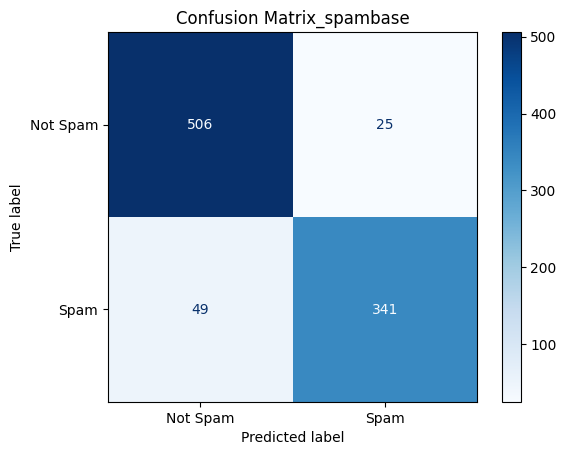

In [17]:
# Train the Logistic Regression model
model = LogisticRegression(random_state=42, max_iter=1000)  
model.fit(X_train, y_train)

# Evaluate the model
acc = model.score(X_test, y_test)  
print(f"Accuracy: {acc:.4f}")


y_pred = model.predict(X_test)


cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Spam", "Spam"])
disp.plot(cmap=plt.cm.Blues)

plt.title("Confusion Matrix_spambase")
plt.show()

### Fl

In [18]:
def split_data_equal(X: np.ndarray, y: np.ndarray, n_clients: int, shuffle: bool=False):

  if shuffle:
    idx = np.random.permutation(X.shape[0])
    X = X[idx]
    y = y[idx]

  n_entries_per_client = X.shape[0] // n_clients
  partitions = []
  for i in range(n_clients):
    start = i*n_entries_per_client
    end = (i+1)*n_entries_per_client
    X_i = X[start:end]
    y_i = y[start:end]
    partitions.append((X_i, y_i))
  partitions[-1] = (X[start:], y[start:])

  return partitions

In [19]:
# Split data among clients
partitions = split_data_equal(X_train, y_train, n_clients=10, shuffle=True)

In [20]:
def train_client_models(partitions, random_seed, X_test, y_test, max_iter):
    client_models = []
    client_global_accuracies = []
    client_local_accuracies = []

    for X_i, y_i in partitions:
        # Remove rows with NaN values
        nan_mask = ~np.isnan(X_i).any(axis=1)
        X_i_clean = X_i[nan_mask]
        y_i_clean = y_i[nan_mask]

        if len(y_i_clean) == 0:
            client_models.append(None)
            client_global_accuracies.append(None)
            client_local_accuracies.append(None)
            continue

        # Train Logistic Regression
        model = LogisticRegression(random_state=random_seed, max_iter=max_iter)
        try:
            model.fit(X_i_clean, y_i_clean)
            client_models.append(model)

            # Compute local accuracy on client data
            acc_local = model.score(X_i_clean, y_i_clean)
            client_local_accuracies.append(acc_local)

            # Compute accuracy on the global test set
            local_acc = model.score(X_test, y_test)
            client_global_accuracies.append(local_acc)

        except Exception as e:
            client_models.append(None)
            client_global_accuracies.append(None)
            client_local_accuracies.append(None)

    return client_models, client_local_accuracies, client_global_accuracies


def run_federated_learning(
    partitions,
    n_clients=10,
    random_seed=None,
    max_iter=1000,
):

    partitions_copy = copy.deepcopy(partitions)

    # Train models for each client and compute accuracies
    client_models, client_local_accuracies, client_global_accuracies = train_client_models(
        partitions_copy, random_seed, X_test, y_test, max_iter
    )

    # Generate all possible combinations of clients represented as binary strings
    results = []
    n_combinations = 2 ** n_clients
    for i in range(1, n_combinations):
        bin_str = format(i, f'0{n_clients}b')
        # Determine which clients are included in this combination
        client_indices = [j for j in range(n_clients) if bin_str[n_clients - 1 - j] == '1']
        included_models = [client_models[j] for j in client_indices if client_models[j] is not None]

        if not included_models:
            # Skip combinations where no valid models are available
            continue

        # Aggregate models
        federated_model = aggregate_lr_models(included_models)
        agg_acc = federated_model.score(X_test, y_test)

        # Prepare the row data
        row = {'Combination': bin_str, 'Clients': [client + 1 for client in client_indices], 'Global Accuracy': agg_acc}

        # Add global accuracies for each client
        for j in range(n_clients):
            acc = client_global_accuracies[j] if client_global_accuracies[j] is not None else np.nan
            row[f"Client {j + 1} Accuracy"] = acc

        results.append(row)

    # Save results to CSV
    df_results = pd.DataFrame(results)
    file_name = "spambase_federated_logestic_reg_results.csv"
    df_results.to_csv(file_name, index=False)
    print(f"Results saved to {file_name}")

    return df_results, client_local_accuracies, client_global_accuracies


In [21]:
# Unpack the returned tuple
df_results, client_local_accuracies, client_global_accuracies = run_federated_learning(
    partitions, n_clients=10, random_seed=42, max_iter=1000
)

Results saved to spambase_federated_logestic_reg_results.csv


In [22]:
top_results = df_results.sort_values(by=['Global Accuracy'], ascending=False).head(5)
top_results

,Combination,Clients,Global Accuracy,Client 1 Accuracy,Client 2 Accuracy,Client 3 Accuracy,Client 4 Accuracy,Client 5 Accuracy,Client 6 Accuracy,Client 7 Accuracy,Client 8 Accuracy,Client 9 Accuracy,Client 10 Accuracy
48,0000110001,"[1, 5, 6]",0.940282,0.914224,0.880565,0.901194,0.888165,0.919653,0.906623,0.895765,0.90228,0.904452,0.897937
304,0100110001,"[1, 5, 6, 9]",0.938111,0.914224,0.880565,0.901194,0.888165,0.919653,0.906623,0.895765,0.90228,0.904452,0.897937
564,1000110101,"[1, 3, 5, 6, 10]",0.937025,0.914224,0.880565,0.901194,0.888165,0.919653,0.906623,0.895765,0.90228,0.904452,0.897937
572,1000111101,"[1, 3, 4, 5, 6, 10]",0.937025,0.914224,0.880565,0.901194,0.888165,0.919653,0.906623,0.895765,0.90228,0.904452,0.897937
308,0100110101,"[1, 3, 5, 6, 9]",0.935939,0.914224,0.880565,0.901194,0.888165,0.919653,0.906623,0.895765,0.90228,0.904452,0.897937


In [23]:
nash_df = find_nash_equilibria_v2(df_results)
nash_df

,Combination,Clients,Global Accuracy
0,1111111111,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",0.926167


      Client  Local Accuracy  Normalized Shapley Value
4   Client 5        0.919653                  0.107575
0   Client 1        0.914224                  0.104796
5   Client 6        0.906623                  0.104202
8   Client 9        0.904452                  0.100366
7   Client 8        0.902280                  0.099461
9  Client 10        0.897937                  0.099236
2   Client 3        0.901194                  0.099163
6   Client 7        0.895765                  0.096661
3   Client 4        0.888165                  0.096421
1   Client 2        0.880565                  0.092118


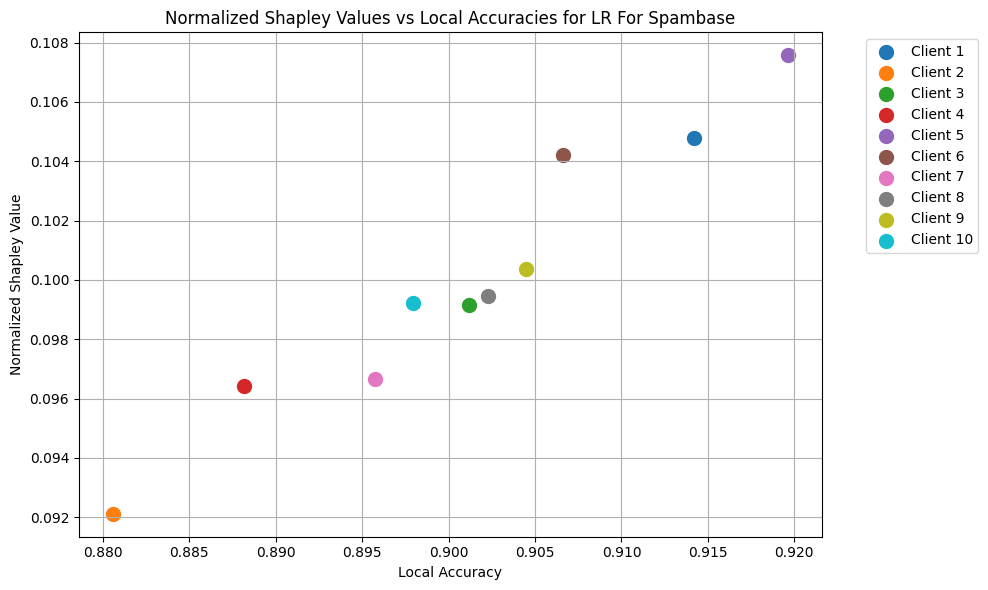

In [24]:
result = compute_and_visualize_shapley_values(
    df_results, 
    client_local_accuracies={i: client_global_accuracies[i] for i in range(n_clients)}, 
    n_clients=10,  
    plot=True,  
    model_name="LR For Spambase",  
    print_df=True 
)


## Checking Nash For Spambase in 10 and 100 Max_iter

In [ ]:
n_trials = 10
n_clients = 10
random_seed = 42

# List of max_iter values to test
max_iters = [10, 100]  

all_nash_details = []

# Loop over each max_iter value
for max_iter in max_iters:
    print(f"\nRunning experiment for max_iter = {max_iter}")
    nash_counts = Counter()
    details_for_this_max_iter = []

    for trial in range(n_trials):
        print(f"  Running trial {trial + 1}/{n_trials} for max_iter = {max_iter}...")
        
        # Set a different random seed for each trial
        trial_seed = np.random.randint(0, 100000)
        np.random.seed(trial_seed)
        
        # Split data for the trial 
        X = df.iloc[:, :-1].to_numpy()
        y = df.iloc[:, -1].to_numpy()
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=trial_seed)
        
        # Normalize data
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        
        # Split data among clients with shuffling 
        partitions = split_data_equal(X_train, y_train, n_clients=n_clients, shuffle=True)
        
        # Run federated learning for the trial 
        df_results, client_local_accuracies, client_global_accuracies = run_federated_learning(
            partitions, n_clients=n_clients, random_seed=trial_seed, max_iter=max_iter
        )
        

        if isinstance(client_local_accuracies, list):
            client_local_accuracies = {i: client_local_accuracies[i] for i in range(len(client_local_accuracies))}
        
        # Find Nash equilibria for this trial 
        df_nash = find_nash_equilibria_v2(df_results)
        
        # Count Nash equilibrium occurrences for this trial
        for coalition in df_nash['Combination']:
            nash_counts[coalition] += 1
        
        # Compute Shapley values for this trial 
        df_shapley = compute_and_visualize_shapley_values(df_results, client_local_accuracies, n_clients=n_clients, plot=False)
        df_shapley['Trial'] = trial + 1
        
        for idx, nash_row in df_nash.iterrows():
            combination_bin = nash_row['Combination']
            client_indices = [j for j in range(n_clients) if combination_bin[n_clients - 1 - j] == '1']
            clients_list = [j + 1 for j in client_indices]
            detail_record = {}
            detail_record['Trial'] = trial + 1
            detail_record['Combination'] = combination_bin
            detail_record['Clients'] = ",".join(str(c) for c in clients_list)
            for client in range(1, n_clients + 1):
                if client in clients_list:
                    detail_record[f'Client {client} Accuracy'] = client_global_accuracies[client - 1]
                    val = df_shapley.loc[df_shapley['Client'] == f'Client {client}', 'Normalized Shapley Value']
                    detail_record[f'Client {client} Shapley Value'] = val.values[0] if not val.empty else np.nan
                else:
                    detail_record[f'Client {client} Accuracy'] = np.nan
                    detail_record[f'Client {client} Shapley Value'] = np.nan
            detail_record['Global Accuracy'] = nash_row['Global Accuracy']
            detail_record['Max Iter'] = max_iter
            details_for_this_max_iter.append(detail_record)
    

    df_nash_counts = pd.DataFrame(nash_counts.items(), columns=['Nash Equilibrium', 'Occurrences'])
    df_nash_counts['Max Iter'] = max_iter
    filename_counts = f"Nash_Equilibrium_Counts_SpambaseLR_maxiter_{max_iter}.csv"
    df_nash_counts.to_csv(filename_counts, index=False)
    print(f"Nash equilibrium counts saved to {filename_counts}")
    
    df_details = pd.DataFrame(details_for_this_max_iter)
    all_nash_details.append(df_details)

final_details_df = pd.concat(all_nash_details, ignore_index=True)
final_details_df.to_csv("Nash_Equilibrium_Details_SpambaseLR.csv", index=False)


print("Nash equilibrium details saved to Nash_Equilibrium_Details_SpambaseLR.csv")